In [1]:
%matplotlib widget

from collections import Counter
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
from rust_ephem import TLEEphemeris
from tqdm.notebook import tqdm

from conops.common import unixtime2date
from conops.config import Config
from conops.ditl import QueueDITL
from conops.targets import Pointing, Queue
from conops.visualization import plot_ditl_telemetry, plot_ditl_timeline, plot_acs_mode_distribution

## DITL Configuration

### Set time period to run DITL over

In this example, we'll start on November 11, 2025 and run for 1 day.

In [2]:
length = 1
begin = datetime(2025, 11, 1)  # , tzinfo=timezone.utc)
end = begin + timedelta(days=length)

### Generate an Ephemeris for the time period

Using the TLE and the time period defined above, we generate an ephemeris for the spacecraft. This ephemeris will contain the position and velocity of the spacecraft for the entire simulation period, which is essential for determining what the spacecraft can see and when.


In [3]:
eph = TLEEphemeris(
    begin=begin,
    end=end,
    tle="example.tle",
    step_size=60,
)

EOP2 text loaded from cache: /Users/jamie/.cache/rust_ephem/latest_eop2.short (age: 13314s)
UT1 provider initialized successfully (EOP2 short, cached)


### Configure the SpaceCraft Model for the DITL

Read in the Spacecraft configuration from JSON.


In [4]:
# Read JSON from disk
config = Config.from_json_file("example_config.json")

# Note that the ephemeris is not serialized, so we need to set it again
config.constraint.ephem = eph

### Ingest Targets for the DITL simulation

In this step we ingest targets into our simulation. This could be a list of
real science targets, an astronomical catalogue. For this simple example, we'll
just generate a list of random points on the sky.


In [5]:
number_of_targets = 1000
target_ra, target_dec = (
    np.random.uniform(0, 360, number_of_targets),
    np.random.uniform(-90, 90, number_of_targets),
)
print(f"Number of pointings = {len(target_ra)}")

Number of pointings = 1000


### Populate Target Queue

Take the list of targets, and use them to populate the Target `Queue`. This also
pre-calculates the visibility windows for each target. 

In [6]:
targids = list(range(10000, 10000 + len(target_ra)))

targlist = Queue()
targlist.ephem = eph
for i in tqdm(range(len(targids))):
    pointing = Pointing(
        constraint=config.constraint, acs_config=config.spacecraft_bus.attitude_control
    )
    pointing.merit = 40
    pointing.ra = target_ra[i]
    pointing.dec = target_dec[i]
    pointing.obsid = targids[i]
    pointing.name = f"pointing_{pointing.obsid}"
    pointing.exptime = 5000
    pointing.visibility()
    targlist.append(pointing)

  0%|          | 0/1000 [00:00<?, ?it/s]

### Set up the Queue Scheduled DITL


In [7]:
config.spacecraft_bus.power_draw.nominal_power = 100
ditls = list()
for i in range(1):
    targlist.reset()
    ditl = QueueDITL(config=config)
    # ditl.acs.request_safe_mode(
    #    utime=begin.timestamp() + 42000
    # )  # Request safe mode at t=42000s
    ditl.acs.last_slew = None
    ditl.queue = targlist
    ditl.ephem = eph
    ditl.begin = begin
    ditl.end = end
    ditl.calc()
    ditls.append(ditl)

Scheduling groundstation passes...
Scheduled pass: 2025-305-07:56:00   NBO   8.0 mins
Scheduled pass: 2025-305-09:08:00   NPO   8.0 mins
Scheduled pass: 2025-305-15:34:00   NPO   8.0 mins
2025-305-00:00:00, RA: 16.02786745162226, Dec: 13.811909277581307, Mode: SCIENCE
2025-305-00:00:00 Fetching new PPT from Queue (last RA/Dec 0.00/0.00)
2025-305-00:00:00 Searching 78 targets in queue...
2025-305-00:00:00 Fetched PPT: 2025-305-00:00:00 pointing_10420 (10420) RA=108.1991, Dec=-37.210039, Roll=-1.0, Merit=100.99050841185243
2025-305-00:00:00: Enqueued SLEW_TO_TARGET command for execution  (queue size: 1)
2025-305-00:01:00: Executing SLEW_TO_TARGET command.
2025-305-00:01:00: Started slew to RA=108.1991360111481 Dec=-37.210039395429106
2025-305-00:01:00, RA: 26.953143858774297, Dec: 5.657574713970599, Mode: SLEWING
2025-305-00:02:00, RA: 41.130762157464034, Dec: -5.465770808974076, Mode: SLEWING
2025-305-00:03:00, RA: 55.84015891123489, Dec: -16.24382721726423, Mode: SLEWING
2025-305-00:04

### Check to see if any Battery charging events happened

In [8]:
# Check for emergency charging behavior
charging_cmds = [
    cmd
    for cmd in ditl.acs.executed_commands
    if "BATTERY_CHARGE" in cmd.command_type.name
]
print(f"Total battery charge commands: {len(charging_cmds)}")
for i, cmd in enumerate(charging_cmds[:20]):  # Show first 20
    print(f"{i}: {unixtime2date(cmd.execution_time)}: {cmd.command_type.name}")

# Check for CHG slews
# chg_slews = [s for s in ditl.acs.slew_history if hasattr(s, 'obstype') and s.obstype == 'CHG']
# print(f"\nTotal CHG slews: {len(chg_slews)}")
# for i, slew in enumerate(chg_slews[:10]):
#    print(f"{i}: RA={slew.endra:.1f} Dec={slew.enddec:.1f} obsid={slew.obsid}")

Total battery charge commands: 5
0: 2025-305-17:11:00: START_BATTERY_CHARGE
1: 2025-305-17:27:00: END_BATTERY_CHARGE
2: 2025-305-17:28:00: START_BATTERY_CHARGE
3: 2025-305-17:31:00: END_BATTERY_CHARGE
4: 2025-305-17:44:00: START_BATTERY_CHARGE


### Plot the output of the DITL simulation

This plot shows spacecraft RA/Dec over time, ACS mode, Battery Charge, Solar
Panel illumination, power level and observation ID

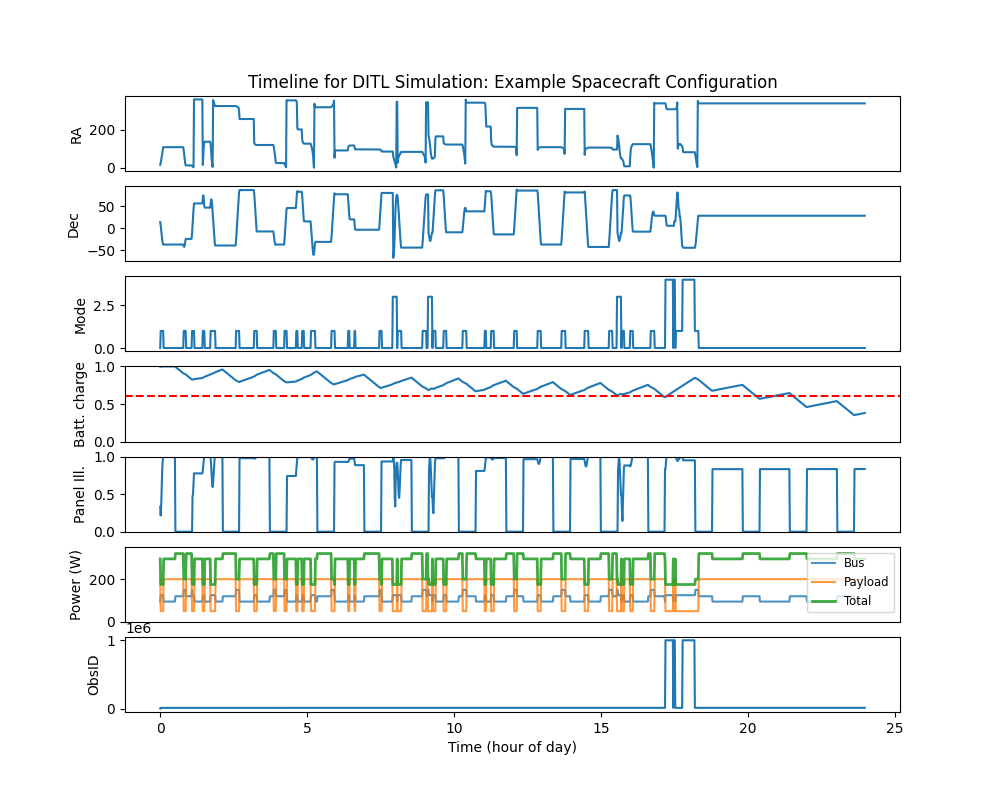

In [9]:
# Plot DITL results
fig, axes = plot_ditl_telemetry(ditl)
plt.show()

### Plot a Histogram showing Observing Efficiency

This histogram plots the time in differing ACS modes, from which we can judge
the overall uptime for 

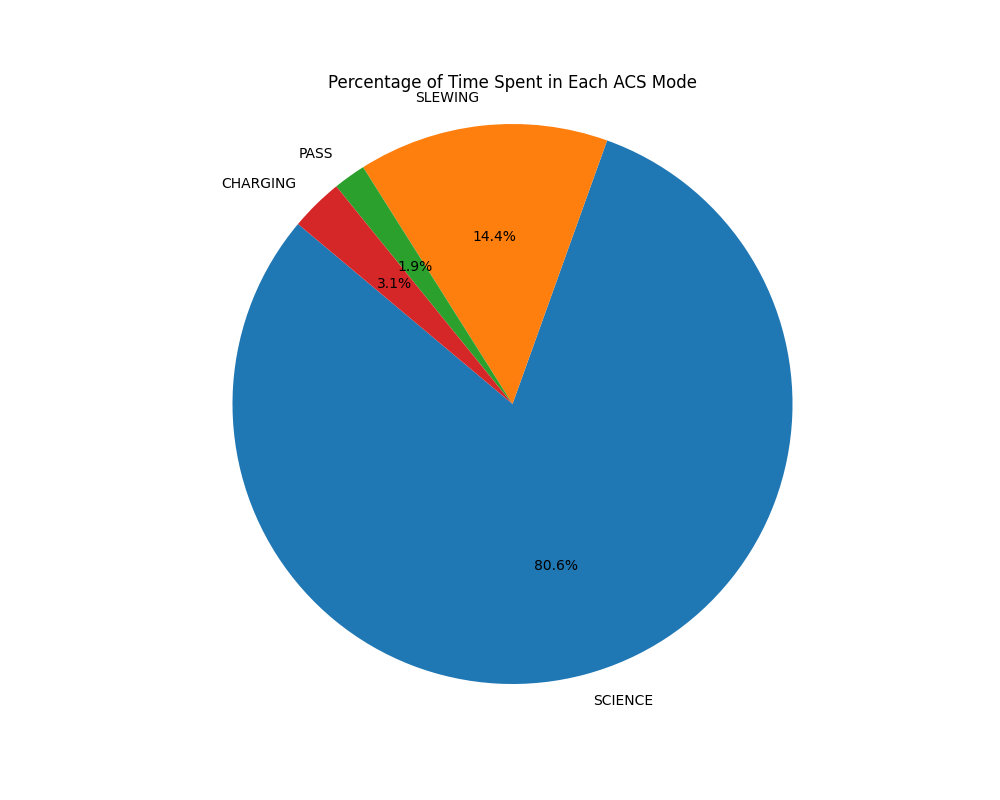

In [14]:
# Plot ACS mode distribution
fig, ax = plot_acs_mode_distribution(ditl)
plt.show()

### Print some summary statistics about the DITL sim

In [11]:
ditl.print_statistics()

DITL SIMULATION STATISTICS

Configuration: Example Spacecraft Configuration
Start Time: 2025-11-01 00:00:00 UTC
End Time: 2025-11-02 00:00:00 UTC
Duration: 24.00 hours (1.00 days)
Time Steps: 1440
Step Size: 60 seconds

----------------------------------------------------------------------
MODE DISTRIBUTION
----------------------------------------------------------------------
Mode                 Count      Percentage   Time (hours)   
----------------------------------------------------------------------
SCIENCE              1161        80.62%           19.35
SLEWING              208         14.44%            3.47
PASS                 27           1.88%            0.45
CHARGING             44           3.06%            0.73

----------------------------------------------------------------------
OBSERVATION STATISTICS
----------------------------------------------------------------------
Total Unique Observations: 33
Total Observation Steps: 1396

Top 10 Observations by Time:
ObsID   

#### Plot DITL Visualization

Show the orbit events more clearly

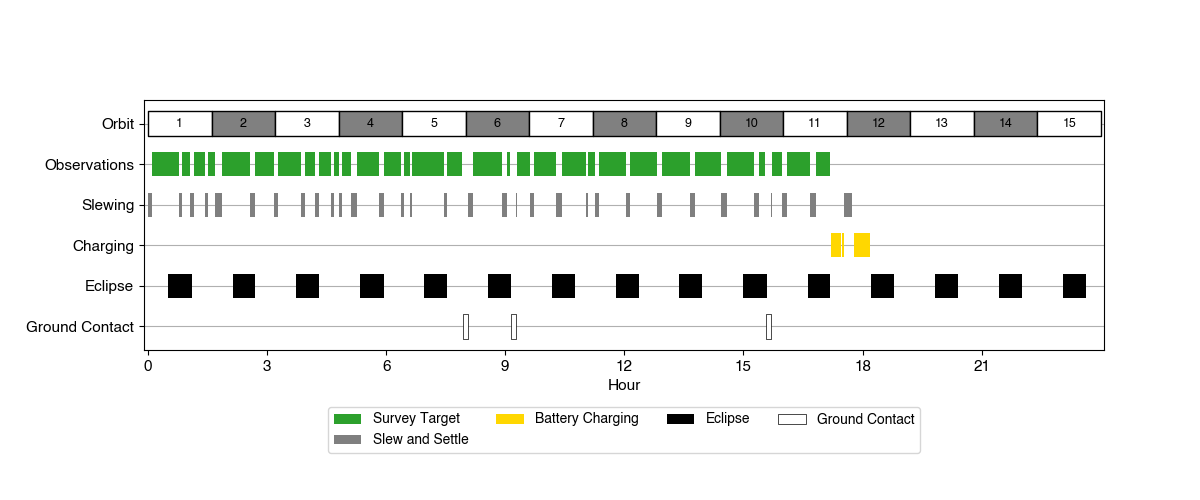

In [12]:
fig, ax = plot_ditl_timeline(
    ditl,
    offset_hours=0,
    figsize=(12, 5),
    orbit_period=5762.0,
    show_orbit_numbers=True,
    font_family="Helvetica",
    font_size=11,
)

plt.show()

In [13]:
_ = [print(ppt, unixtime2date(ppt.end)) for ppt in ditl.plan]

2025-305-00:00:00 pointing_10420 (10420) RA=108.1991, Dec=-37.210039, Roll=-1.0, Merit=100.99050841185243 2025-305-00:47:00
2025-305-00:47:00 pointing_10060 (10060) RA=12.6639, Dec=-24.459556, Roll=-1.0, Merit=100.99878135799973 2025-305-01:04:00
2025-305-01:04:00 pointing_10018 (10018) RA=358.2272, Dec=56.261306, Roll=-1.0, Merit=100.9898594643092 2025-305-01:26:00
2025-305-01:26:00 pointing_10571 (10571) RA=136.8518, Dec=46.729976, Roll=-1.0, Merit=100.99056788798889 2025-305-01:42:00
2025-305-01:42:00 pointing_10086 (10086) RA=323.4771, Dec=-39.406430, Roll=-1.0, Merit=100.97763521497484 2025-305-02:34:00
2025-305-02:34:00 pointing_10840 (10840) RA=255.7067, Dec=86.616389, Roll=-1.0, Merit=100.99904588085683 2025-305-03:11:00
2025-305-03:11:00 pointing_10887 (10887) RA=119.5902, Dec=-7.452606, Roll=-1.0, Merit=100.93224770052026 2025-305-03:51:00
2025-305-03:51:00 pointing_10243 (10243) RA=24.9794, Dec=-37.203245, Roll=-1.0, Merit=100.99927701880617 2025-305-04:13:00
2025-305-04:13: